### ILI activiy prediction from Lat, Long

# Import module

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

import pandas as pd
from pandas import read_csv
from datetime import datetime

import math, time
from math import sqrt

import itertools
import sklearn

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)



import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model

import h5py

# Input parameters 

In [13]:
data = '../data/raw.csv'
seq_len = 22
d = 0.2 #decay
shape = [3, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

# 1. Download data and normalize it
Data since 2010 to 2015

In [14]:
#TO DO : create a function to preprocess the data
@memory.cache
def get_ili_data(data, normalize=True):
    
    df = read_csv(data, index_col=3)
    
    # manually specify column names
    df.columns = ['statename','activity_level','activity_level_label','season','weeknumber','Latitude','Longitude']
    df.index.name = 'date'
    
    # convert index to datetime
    df.index = pd.to_datetime(df.index, format='%b-%d-%Y')
    
    # manually remove the feature we don;t want to evaluate 
    df.drop(['statename', 'season', 'weeknumber','activity_level_label'], axis=1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['activity_level'] = min_max_scaler.fit_transform(df.activity_level.values.reshape(-1,1))
        df['Latitude'] = min_max_scaler.fit_transform(df.Latitude.values.reshape(-1,1))
        df['Longitude'] = min_max_scaler.fit_transform(df.Longitude.values.reshape(-1,1))
    return df

In [15]:
df = get_ili_data(data, normalize=True)
# summarize first 5 rows
print(df.head(5))

            activity_level  Latitude  Longitude
date                                           
2016-10-01             0.1  0.290799    0.80243
2016-09-24             0.1  0.290799    0.80243
2016-09-17             0.1  0.290799    0.80243
2016-09-10             0.1  0.290799    0.80243
2016-09-03             0.1  0.290799    0.80243


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# 2. Plot out the ILI activity level

In [28]:
@memory.cache
def plot_ili(data):
    df = get_ili_data(data, normalize=True)
    print(df.head())
    plt.plot(df['activity_level'].values, color='red', label='ILI activity')
    plt.legend(loc='best')
    plt.show()
    
def plot_ili_group(data):
    df = get_ili_data(data, normalize=False)
    print(df.head())
    values = df.values
    # specify columns to plot
    groups = [0,1,2]
    i = 1
    # plot each column
    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.5, loc='right')
        plt.legend(loc='best')
        i += 1
    plt.show()


            activity_level  Latitude  Longitude
date                                           
2016-10-01             0.1  0.290799    0.80243
2016-09-24             0.1  0.290799    0.80243
2016-09-17             0.1  0.290799    0.80243
2016-09-10             0.1  0.290799    0.80243
2016-09-03             0.1  0.290799    0.80243


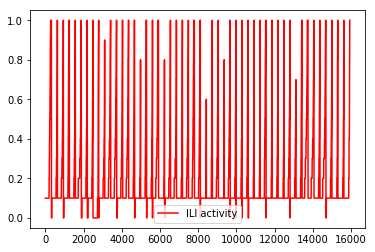

In [29]:
plot_ili(data)
# plot_ili_group(data)

# 3. Set last day Adjusted Close as y

In [30]:
@memory.cache
def load_data(ili_data, seq_len):
    amount_of_features = len(ili_data.columns)
    data = ili_data.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [31]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [32]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(14319, 22, 3)

In [33]:
y_train.shape[0]

14319

# 4. Buidling neural network

In [34]:
@memory.cache
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [35]:
model = build_model2(shape, neurons, d)
# layers = [3, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 22, 128)           67584     
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 203,329
Trainable params: 203,329
Non-trainable params: 0
_________________________________________________________________


TypeError: can't pickle _thread.lock objects

In [36]:
@memory.cache
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

SyntaxError: invalid syntax (<ipython-input-36-4d5419ecfbca>, line 2)

# 7. Result on training set and testing set

In [52]:
@memory.cache
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [53]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00025 MSE (0.02 RMSE)
Test Score: 0.00031 MSE (0.02 RMSE)


(0.00024660477642904745, 0.00030625113549688526)

# 8. Prediction vs Real results

In [54]:
@memory.cache
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [55]:
p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [56]:
def denormalize(data, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = read_csv(data, index_col=3)
    
    df = df['activity_level'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [57]:
def plot_result(data, normalized_value_p, normalized_value_y_test):
    newp = denormalize(data, normalized_value_p)
    newy_test = denormalize(data, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format('ILI activity'))
    plt2.xlabel('Days')
    plt2.ylabel('Activity_level')
    plt2.show()

In [59]:
plot_result(data, p, y_test)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

# 10. Save for consistency

In [ ]:
# model.save('LSTM_Stock_prediction-20170429.h5')

# Part 2. Fine tune model
# 11. Function to load data, train model and see score

In [ ]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [ ]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

# 12. Fine tune hyperparameter

12.1 Optimial Dropout value

In [23]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

In [24]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (dropout_result)
print (min_val_key)

{0.2: 9.0012162654516434e-05, 0.3: 0.0022254438251234927, 0.8: 0.15819754752706974, 0.5: 0.01902325010867283, 0.7: 0.067955376763099332, 0.4: 0.01020233225110141, 0.6: 0.038046965636445065}
[0.2]


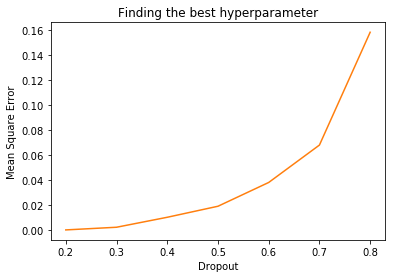

In [34]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

12.2 Optimial epochs value

In [29]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochslist = [10,20,30,40,50,60,70,80,90,100]

In [30]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

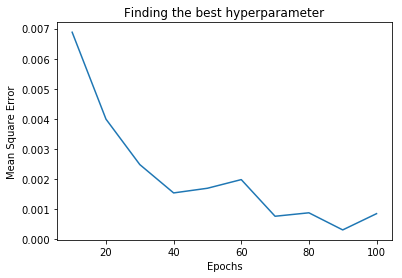

In [31]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

12.3 Optimal number of neurons

In [12]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
epochs = 90
dropout = 0.3
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 32)            4736      
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

In [112]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

NameError: name 'neurons_result' is not defined

12.4 Optimial Dropout value

In [ ]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [256, 256, 32, 1]
epochs = 90
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
def build_model3(layers, neurons, d, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model3(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [ ]:
decay_result = {}

for decay in decaylist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

In [ ]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

In [ ]:
stock_name = '^GSPC'
neurons = [256, 256, 32, 1]
epochs = 90
d = 0.3 #dropout
decay = 0.4

In [ ]:
seq_len_list = [5, 10, 22, 60, 120, 180]

seq_len_result = {}

for seq_len in seq_len_list:
    shape = [4, seq_len, 1]
    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    seq_len_result[seq_len] = testScore

In [ ]:
lists = sorted(seq_len_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()